# Model Comparison for Edge Probability Prediction

This notebook compares 4 different models for predicting edge probabilities based on source and target node degrees:

1. **Simple Neural Network**: 2-layer NN with continuous probability output
2. **Random Forest**: Ensemble method with 100 trees
3. **Logistic Regression**: Standard logistic regression with L2 regularization
4. **Polynomial Logistic Regression**: Quadratic features + logistic regression

## Data

We use edge data from a single permutation: `data/permutations/000.hetmat/edges/AeG.sparse.npz`

## Evaluation

Models are evaluated using:
- **Classification metrics**: AUC-ROC, Precision, Recall, F1-Score
- **Regression metrics**: RMSE, MAE, R², Correlation
- **Empirical comparison**: Compare predictions with empirical frequencies from `results/edge_frequency_by_degree.csv`
- **Visualizations**: ROC curves, Precision-Recall curves, probability heatmaps

## 1. Setup and Data Loading

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
results_dir = repo_dir / 'results' / 'model_comparison'
results_dir.mkdir(parents=True, exist_ok=True)

sys.path.append(str(src_dir))

# Import our custom modules
from model_comparison import ModelCollection, prepare_edge_features_and_labels, create_degree_grid
from model_training import ModelTrainer
from model_evaluation import ModelEvaluator, get_best_models
from model_visualization import ModelVisualizer, create_comparison_table_plot

print("All modules imported successfully!")
print(f"Repository directory: {repo_dir}")
print(f"Results will be saved to: {results_dir}")

All modules imported successfully!
Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
Results will be saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/model_comparison


## 2. Data Preparation

In [2]:
# Parameters
EDGE_FILE_PATH = data_dir / 'permutations' / '000.hetmat' / 'edges' / 'AeG.sparse.npz'
SAMPLE_RATIO = 0.1  # Ratio for negative sampling to balance dataset
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1

print(f"Loading edge data from: {EDGE_FILE_PATH}")
print(f"File exists: {EDGE_FILE_PATH.exists()}")

if not EDGE_FILE_PATH.exists():
    raise FileNotFoundError(f"Edge data file not found: {EDGE_FILE_PATH}")

Loading edge data from: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/AeG.sparse.npz
File exists: True


In [3]:
# Prepare features and labels
print("Preparing edge features and labels...")
features, labels = prepare_edge_features_and_labels(
    str(EDGE_FILE_PATH), 
    sample_ratio=SAMPLE_RATIO
)

print(f"\nDataset Statistics:")
print(f"  Total samples: {len(features)}")
print(f"  Features shape: {features.shape}")
print(f"  Positive examples: {np.sum(labels)} ({np.mean(labels):.1%})")
print(f"  Negative examples: {len(labels) - np.sum(labels)} ({1-np.mean(labels):.1%})")

print(f"\nFeature Statistics:")
print(f"  Source degrees: {features[:, 0].min():.0f} - {features[:, 0].max():.0f} (mean: {features[:, 0].mean():.1f})")
print(f"  Target degrees: {features[:, 1].min():.0f} - {features[:, 1].max():.0f} (mean: {features[:, 1].mean():.1f})")

Preparing edge features and labels...
Dataset prepared:
  Positive examples: 526407
  Negative examples: 5264070
  Total examples: 5790477
  Feature shape: (5790477, 2)

Dataset Statistics:
  Total samples: 5790477
  Features shape: (5790477, 2)
  Positive examples: 526407.0 (9.1%)
  Negative examples: 5264070.0 (90.9%)

Feature Statistics:
  Source degrees: 0 - 15036 (mean: 1533.6)
  Target degrees: 0 - 98 (mean: 25.6)


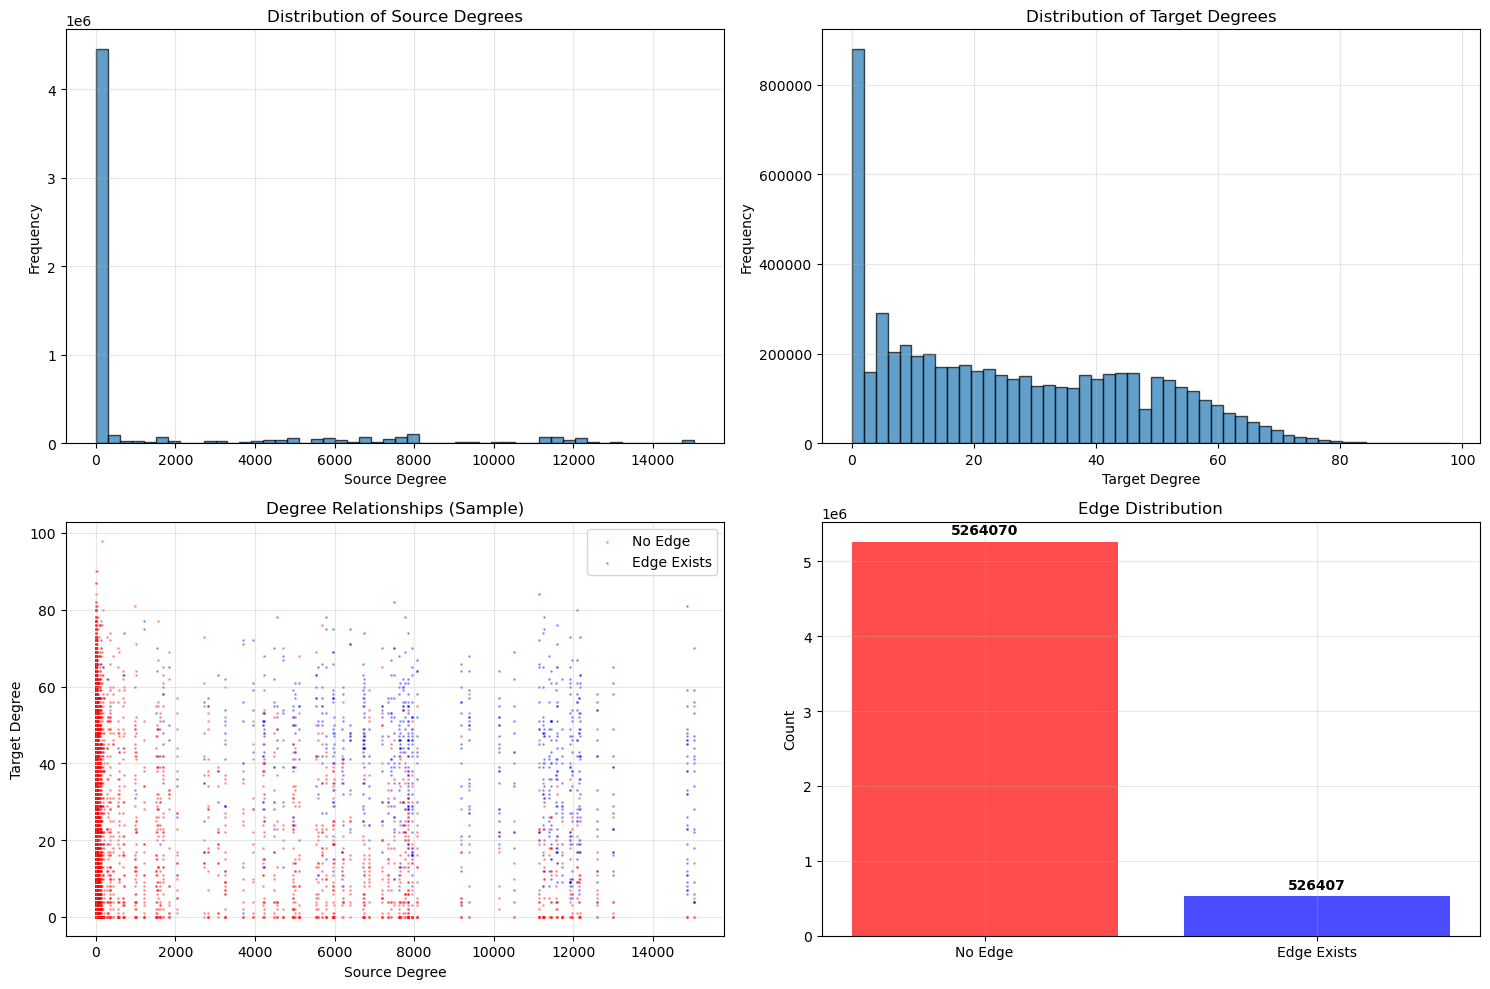

Data distribution visualized and saved.


In [4]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Source degree distribution
axes[0, 0].hist(features[:, 0], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Source Degree')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Source Degrees')
axes[0, 0].grid(True, alpha=0.3)

# Target degree distribution
axes[0, 1].hist(features[:, 1], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Target Degree')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Target Degrees')
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot of degrees (colored by edge existence)
positive_mask = labels == 1
negative_mask = labels == 0

# Sample for visualization (too many points otherwise)
n_sample = min(10000, len(features))
sample_idx = np.random.choice(len(features), n_sample, replace=False)

axes[1, 0].scatter(features[sample_idx[negative_mask[sample_idx]], 0], 
                   features[sample_idx[negative_mask[sample_idx]], 1], 
                   alpha=0.3, s=1, label='No Edge', color='red')
axes[1, 0].scatter(features[sample_idx[positive_mask[sample_idx]], 0], 
                   features[sample_idx[positive_mask[sample_idx]], 1], 
                   alpha=0.3, s=1, label='Edge Exists', color='blue')
axes[1, 0].set_xlabel('Source Degree')
axes[1, 0].set_ylabel('Target Degree')
axes[1, 0].set_title('Degree Relationships (Sample)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Label distribution
label_counts = pd.Series(labels).value_counts().sort_index()
axes[1, 1].bar(['No Edge', 'Edge Exists'], label_counts.values, 
               color=['red', 'blue'], alpha=0.7)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Edge Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add count labels on bars
for i, count in enumerate(label_counts.values):
    axes[1, 1].text(i, count + len(features) * 0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Data distribution visualized and saved.")

## 3. Model Creation and Training

In [5]:
# Create all models
model_collection = ModelCollection(random_state=RANDOM_STATE)
models = model_collection.create_models(use_class_weights=True)  # Enable class weighting for NN
model_info = model_collection.get_model_info()

print("Models created:")
print("=" * 50)
for name, description in model_info.items():
    print(f"{name}:")
    print(f"  {description}")
    print()

print("Neural Network configured with class imbalance weighting (BCEWithLogitsLoss)")
print("Other models use default configurations")

Models created:
Simple NN:
  Neural Network with 2 hidden layers (128, 64 neurons), ReLU activation, dropout=0.3

Random Forest:
  Random Forest Classifier with 100 trees, max_depth=10

Logistic Regression:
  Standard logistic regression with L2 regularization

Polynomial Logistic Regression:
  Polynomial features (degree=2) + Logistic regression

Neural Network configured with class imbalance weighting (BCEWithLogitsLoss)
Other models use default configurations


In [6]:
# Train all models
trainer = ModelTrainer(random_state=RANDOM_STATE)
training_results = trainer.train_all_models(
    models, features, labels, 
    test_size=TEST_SIZE, 
    val_size=VAL_SIZE
)

print("\nAll models trained successfully!")

TRAINING ALL MODELS
Total samples: 5790477
Training samples: 4632381 (NN uses 4169142 for training, 463239 for validation)
Test samples: 1158096

Training Simple NN...
  Using Focal Loss (alpha=0.25, gamma=2.0) for class imbalance
  Class weights: Positive=5.500, Negative=0.550
  Positive samples: 379013 (9.1%)
  Negative samples: 3790129 (90.9%)
Training Neural Network:
  Training samples: 4169142
  Validation samples: 463239
  Batch size: 1024
  Max epochs: 80
  Epoch 10/80: Train Loss: 0.0057, Val Loss: 0.0056, Val Acc: 0.9643
  Early stopping at epoch 10
  Training completed in 178.14 seconds
  Best validation loss: 0.0055

Training Random Forest...
Training Random Forest:
  Training samples: 4632381
  Training completed in 17.61 seconds

Training Logistic Regression...
Training Logistic Regression:
  Training samples: 4632381
  Training completed in 0.83 seconds

Training Polynomial Logistic Regression...
Training Polynomial Logistic Regression:
  Training samples: 4632381
  Train

## 4. Model Evaluation

In [7]:
# Evaluate all models
evaluator = ModelEvaluator()
X_test = training_results['data_splits']['X_test']
y_test = training_results['data_splits']['y_test']

evaluation_results = evaluator.evaluate_all_models(training_results, X_test, y_test)

print("Model evaluation completed!")

EVALUATING ALL MODELS
Test samples: 1158096
Positive samples: 105281.0 (0.091)

Evaluating Simple NN...
  AUC: 0.9864
  Accuracy: 0.9640
  F1 Score: 0.8081
  RMSE: 0.1901
  Correlation: 0.7868

Evaluating Random Forest...
  AUC: 0.9876
  Accuracy: 0.9643
  F1 Score: 0.8025
  RMSE: 0.1588
  Correlation: 0.8336

Evaluating Logistic Regression...
  AUC: 0.9772
  Accuracy: 0.9588
  F1 Score: 0.7575
  RMSE: 0.1744
  Correlation: 0.7950

Evaluating Polynomial Logistic Regression...
  AUC: 0.9841
  Accuracy: 0.9629
  F1 Score: 0.7905
  RMSE: 0.1635
  Correlation: 0.8226

Model evaluation completed!


In [8]:
# Print detailed evaluation results
evaluator.print_detailed_results(evaluation_results)


DETAILED EVALUATION RESULTS

SIMPLE NN:
--------------------------------------------------
Test Samples: 1158096
Positive Samples: 105281.0 (9.1%)

Classification Metrics:
  AUC-ROC: 0.9864
  Accuracy: 0.9640
  Precision: 0.7840
  Recall/Sensitivity: 0.8338
  Specificity: 0.9770
  F1 Score: 0.8081
  Average Precision: 0.8813

Confusion Matrix:
  True Positives: 87785
  False Positives: 24189
  True Negatives: 1028626
  False Negatives: 17496

Regression Metrics:
  RMSE: 0.1901
  MAE: 0.1267
  R²: 0.5626
  Correlation: 0.7868

RANDOM FOREST:
--------------------------------------------------
Test Samples: 1158096
Positive Samples: 105281.0 (9.1%)

Classification Metrics:
  AUC-ROC: 0.9876
  Accuracy: 0.9643
  Precision: 0.8073
  Recall/Sensitivity: 0.7978
  Specificity: 0.9810
  F1 Score: 0.8025
  Average Precision: 0.8831

Confusion Matrix:
  True Positives: 83988
  False Positives: 20047
  True Negatives: 1032768
  False Negatives: 21293

Regression Metrics:
  RMSE: 0.1588
  MAE: 0.0

In [9]:
# Create and display comparison table
comparison_df = evaluator.create_comparison_dataframe(evaluation_results)
print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Save comparison table
comparison_df.to_csv(results_dir / 'model_comparison.csv', index=False)
print(f"\nComparison table saved to: {results_dir / 'model_comparison.csv'}")

Model Performance Comparison:
                         Model    AUC  Accuracy  Precision  Recall  F1 Score  Average Precision   RMSE    MAE     R²  Correlation
                 Random Forest 0.9876    0.9643     0.8073  0.7978    0.8025             0.8831 0.1588 0.0505 0.6949       0.8336
                     Simple NN 0.9864    0.9640     0.7840  0.8338    0.8081             0.8813 0.1901 0.1267 0.5626       0.7868
Polynomial Logistic Regression 0.9841    0.9629     0.8128  0.7694    0.7905             0.8711 0.1635 0.0521 0.6767       0.8226
           Logistic Regression 0.9772    0.9588     0.8159  0.7069    0.7575             0.8449 0.1744 0.0598 0.6320       0.7950

Comparison table saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/model_comparison/model_comparison.csv


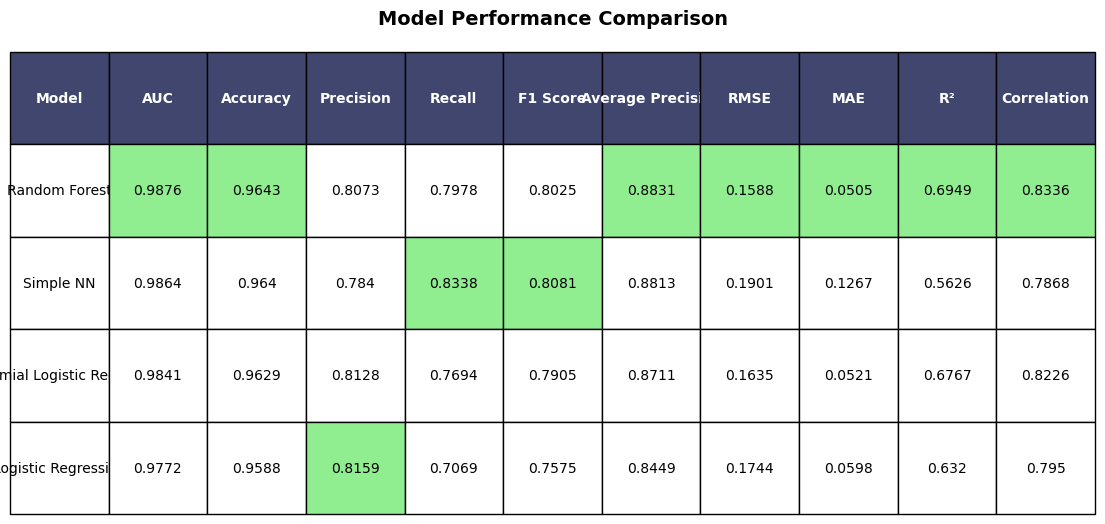

In [10]:
# Visual comparison table
create_comparison_table_plot(comparison_df, save_path=results_dir / 'comparison_table.png')

In [11]:
# Identify best models for each metric
best_models = get_best_models(evaluation_results)

print("Best Models by Metric:")
print("=" * 30)
for metric, model_name in best_models.items():
    print(f"{metric.upper():20}: {model_name}")

Best Models by Metric:
AUC                 : Random Forest
ACCURACY            : Random Forest
F1_SCORE            : Simple NN
AVERAGE_PRECISION   : Random Forest
RMSE                : Random Forest
CORRELATION         : Random Forest


## 4.1. Empirical Frequency Comparison

In this section, we compare model predictions with empirical edge frequencies from the full dataset. This provides insight into how well each model captures the true underlying edge probability distribution based on degree combinations.

In [12]:
# Reimport updated modules to get the new empirical comparison methods
import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import ModelEvaluator, get_best_models

# Create a new evaluator instance with the updated methods
evaluator = ModelEvaluator()

# Re-run evaluation with the new evaluator instance to get fresh results
evaluation_results = evaluator.evaluate_all_models(training_results, X_test, y_test)

print("Reloaded model_evaluation module with updated empirical comparison methods")
print("Created new evaluator instance and re-ran evaluation")

EVALUATING ALL MODELS
Test samples: 1158096
Positive samples: 105281.0 (0.091)

Evaluating Simple NN...
  AUC: 0.9864
  Accuracy: 0.9640
  F1 Score: 0.8081
  RMSE: 0.1901
  Correlation: 0.7868

Evaluating Random Forest...
  AUC: 0.9876
  Accuracy: 0.9643
  F1 Score: 0.8025
  RMSE: 0.1588
  Correlation: 0.8336

Evaluating Logistic Regression...
  AUC: 0.9772
  Accuracy: 0.9588
  F1 Score: 0.7575
  RMSE: 0.1744
  Correlation: 0.7950

Evaluating Polynomial Logistic Regression...
  AUC: 0.9841
  Accuracy: 0.9629
  F1 Score: 0.7905
  RMSE: 0.1635
  Correlation: 0.8226

Reloaded model_evaluation module with updated empirical comparison methods
Created new evaluator instance and re-ran evaluation


Empirical frequency file: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
File exists: True
Loaded empirical frequencies from: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
  Records: 13167
  Source degree range: 1 - 15036
  Target degree range: 1 - 98
  Frequency range: 0.000001 - 1.004902

COMPARING TEST PREDICTIONS WITH EMPIRICAL FREQUENCIES

Comparing Simple NN test predictions with empirical frequencies...
  Matched degree combinations: 597750/1158096 (51.6%)
  MAE vs Empirical: 0.106743
  RMSE vs Empirical: 0.125145
  R² vs Empirical: 0.814477
  Correlation vs Empirical: 0.947605

Comparing Random Forest test predictions with empirical frequencies...
  Matched degree combinations: 597750/1158096 (51.6%)
  MAE vs Empirical: 0.019008
  RMSE vs Empirical: 0.037713
  

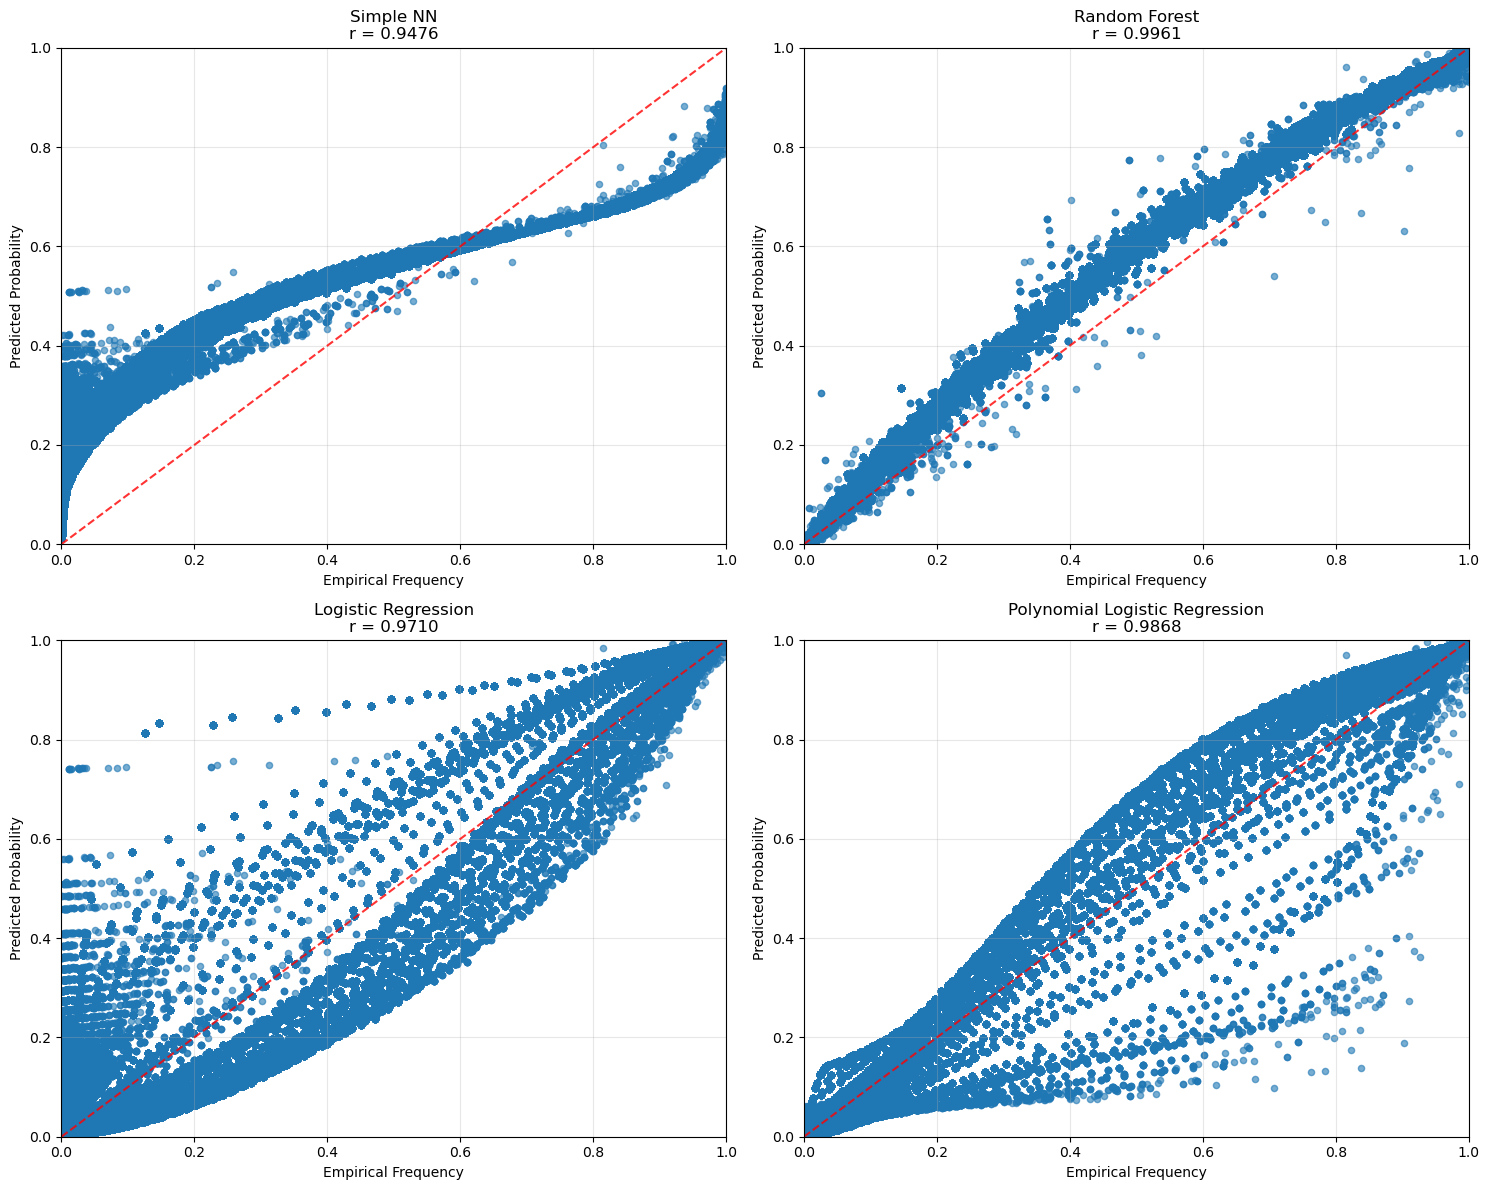

In [13]:
# Test Predictions vs Empirical Frequencies Comparison
EMPIRICAL_FREQ_FILE = repo_dir / 'results' / 'edge_frequency_by_degree.csv'

print(f"Empirical frequency file: {EMPIRICAL_FREQ_FILE}")
print(f"File exists: {EMPIRICAL_FREQ_FILE.exists()}")

if EMPIRICAL_FREQ_FILE.exists():
    # Compare test predictions with empirical frequencies for the same degree combinations
    test_empirical_comparison = evaluator.compare_test_predictions_with_empirical(
        evaluation_results, training_results, X_test, str(EMPIRICAL_FREQ_FILE)
    )
    
    # Print summary
    evaluator.print_test_empirical_comparison_summary(test_empirical_comparison)
    
    # Create comparison dataframe
    test_empirical_df = evaluator.create_test_empirical_comparison_dataframe(test_empirical_comparison)
    print("\nTest Predictions vs Empirical Frequencies Comparison:")
    print("=" * 80)
    print(test_empirical_df.to_string(index=False, float_format='%.6f'))
    
    # Save comparison results
    test_empirical_df.to_csv(results_dir / 'test_vs_empirical_comparison.csv', index=False)
    print(f"\nTest vs empirical comparison saved to: {results_dir / 'test_vs_empirical_comparison.csv'}")
    
    # Create scatter plot comparing predictions vs empirical frequencies
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (model_name, results) in enumerate(test_empirical_comparison.items()):
        if i >= 4:  # Only plot first 4 models
            break
            
        predictions = results['matched_predictions']
        empirical = results['matched_empirical']
        correlation = results['correlation_vs_empirical']
        
        axes[i].scatter(empirical, predictions, alpha=0.6, s=20)
        axes[i].plot([0, 1], [0, 1], 'r--', alpha=0.8)  # Perfect correlation line
        axes[i].set_xlabel('Empirical Frequency')
        axes[i].set_ylabel('Predicted Probability')
        axes[i].set_title(f'{model_name}\nr = {correlation:.4f}')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'test_vs_empirical_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Empirical frequency file not found. Skipping empirical comparison.")
    print("Run the edge frequency analysis first to generate the empirical frequencies.")
    print("This should create the file: results/edge_frequency_by_degree.csv")
    test_empirical_comparison = None
    test_empirical_df = None

## 4.2. Analytical Approximation Evaluation

In this section, we evaluate the analytical approximation formula:

$$P_{i,j} = \frac{u_i v_j}{\sqrt{(u_i v_j)^2 + (m - u_i - v_j + 1)^2}}$$

where:
- $u_i$ is the source node degree
- $v_j$ is the target node degree  
- $m$ is the total number of edges in the network

We first validate this approximation against empirical frequencies, then compare all model predictions to the analytical approximation.

## 4.2.1. Analytical Approximation Validation vs Empirical

In [14]:
# First, reload the evaluator with updated analytical approximation methods
import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import ModelEvaluator

# Create new evaluator instance
evaluator = ModelEvaluator()

# Check if empirical frequency file exists for validation
if EMPIRICAL_FREQ_FILE.exists():
    print(f"Loading empirical frequencies for analytical validation: {EMPIRICAL_FREQ_FILE}")
    
    # Load empirical frequency data
    empirical_df = evaluator.load_empirical_frequencies(str(EMPIRICAL_FREQ_FILE))
    
    # Extract degree combinations and frequencies
    source_degrees_empirical = empirical_df['source_degree'].values
    target_degrees_empirical = empirical_df['target_degree'].values
    empirical_frequencies = empirical_df['empirical_frequency'].values
    
    # Get total number of edges from the edge matrix
    total_edges_m = evaluator.get_total_edges_from_file(str(EDGE_FILE_PATH))
    
    # Validate analytical approximation against empirical frequencies
    validation_results = evaluator.validate_analytical_approximation_vs_empirical(
        source_degrees_empirical, target_degrees_empirical, empirical_frequencies, total_edges_m
    )
    
    print("\nAnalytical approximation validation completed!")
    
else:
    print("Empirical frequency file not found. Skipping analytical validation.")
    print("Run the edge frequency analysis first to generate empirical frequencies.")
    validation_results = None

Loading empirical frequencies for analytical validation: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
Loaded empirical frequencies from: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
  Records: 13167
  Source degree range: 1 - 15036
  Target degree range: 1 - 98
  Frequency range: 0.000001 - 1.004902
Loaded edge matrix from /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/AeG.sparse.npz
  Shape: (402, 20945)
  Total edges: 526407

Analytical Approximation Validation vs Empirical:
  Total edges (m): 526407
  MAE vs Empirical: 0.094323
  RMSE vs Empirical: 0.154343
  R² vs Empirical: 0.832818
  Correlation vs Empirical: 0.959711
  Mean Analytical: 0.222832
  Mean E

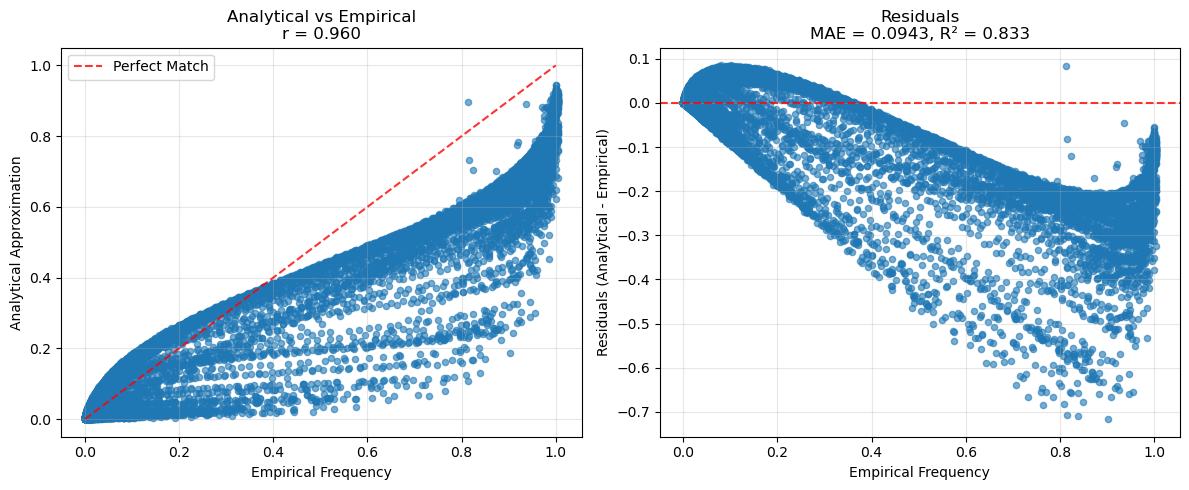

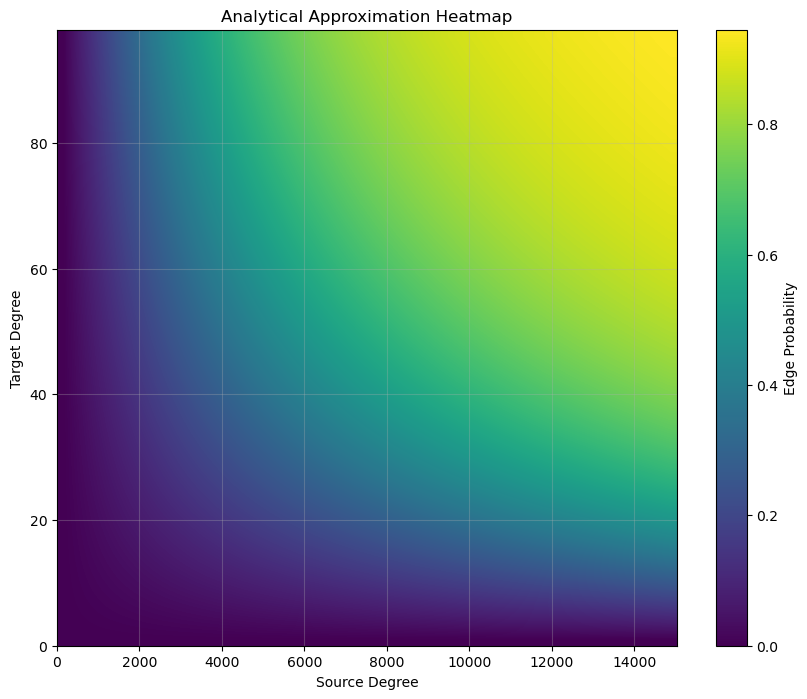

Analytical approximation validation visualizations created!


In [15]:
# Visualize analytical approximation validation (if available)
if validation_results is not None:
    # Reload visualization module to get new methods
    import model_visualization
    importlib.reload(model_visualization)
    from model_visualization import ModelVisualizer
    
    # Create visualizer and plot analytical validation
    visualizer = ModelVisualizer()
    visualizer.plot_analytical_validation(
        validation_results, 
        save_path=results_dir / 'analytical_validation.png'
    )
    
    # Create degree grids for analytical heatmap visualization (needed for this section)
    source_degrees_for_heatmap = features[:, 0]
    target_degrees_for_heatmap = features[:, 1]
    
    source_bins_analytical, target_bins_analytical, _ = create_degree_grid(
        source_degrees_for_heatmap, target_degrees_for_heatmap, n_bins=50
    )
    
    # Create analytical approximation heatmap
    visualizer.create_analytical_heatmap(
        source_bins_analytical, target_bins_analytical, validation_results['total_edges_m'],
        save_path=results_dir / 'analytical_heatmap.png'
    )
    
    print("Analytical approximation validation visualizations created!")
else:
    print("Skipping analytical validation visualizations - no validation data available.")

## 4.2.2. Model Predictions vs Analytical Approximation

In [16]:
# Compare all model predictions with analytical approximation
analytical_comparison = evaluator.compare_models_vs_analytical_approximation(
    evaluation_results, training_results, X_test, str(EDGE_FILE_PATH)
)

# Print summary of analytical comparison
evaluator.print_analytical_comparison_summary(analytical_comparison)

# Create comparison dataframe
analytical_df = evaluator.create_analytical_comparison_dataframe(analytical_comparison)
print("\nModel Predictions vs Analytical Approximation:")
print("=" * 80)
print(analytical_df.to_string(index=False, float_format='%.6f'))

# Save analytical comparison results
analytical_df.to_csv(results_dir / 'models_vs_analytical_comparison.csv', index=False)
print(f"\nAnalytical comparison saved to: {results_dir / 'models_vs_analytical_comparison.csv'}")

Loaded edge matrix from /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/AeG.sparse.npz
  Shape: (402, 20945)
  Total edges: 526407

COMPARING MODEL PREDICTIONS WITH ANALYTICAL APPROXIMATION
Total edges (m): 526407
Test samples: 1158096

Comparing Simple NN with analytical approximation...
  MAE vs Analytical: 0.083641
  RMSE vs Analytical: 0.106639
  R² vs Analytical: 0.606072
  Correlation vs Analytical: 0.938770

Comparing Random Forest with analytical approximation...
  MAE vs Analytical: 0.028404
  RMSE vs Analytical: 0.081210
  R² vs Analytical: 0.771541
  Correlation vs Analytical: 0.985650

Comparing Logistic Regression with analytical approximation...
  MAE vs Analytical: 0.042126
  RMSE vs Analytical: 0.097607
  R² vs Analytical: 0.669971
  Correlation vs Analytical: 0.933009

Comparing Polynomial Logistic Regression with analytical approximation...
  MAE vs Analytical: 0

In [17]:
## 5. Visualizations

## 5. Visualizations

Creating ROC curves...


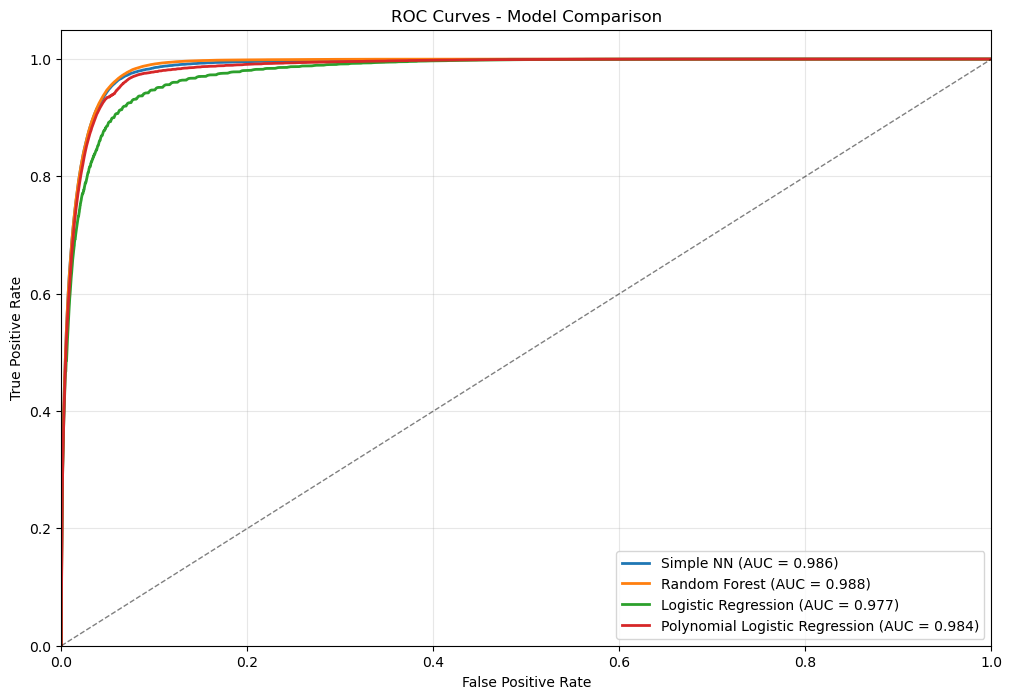

In [18]:
# Create visualizer
visualizer = ModelVisualizer()

# Plot ROC curves
print("Creating ROC curves...")
visualizer.plot_roc_curves(evaluation_results, save_path=results_dir / 'roc_curves.png')

Creating Precision-Recall curves...


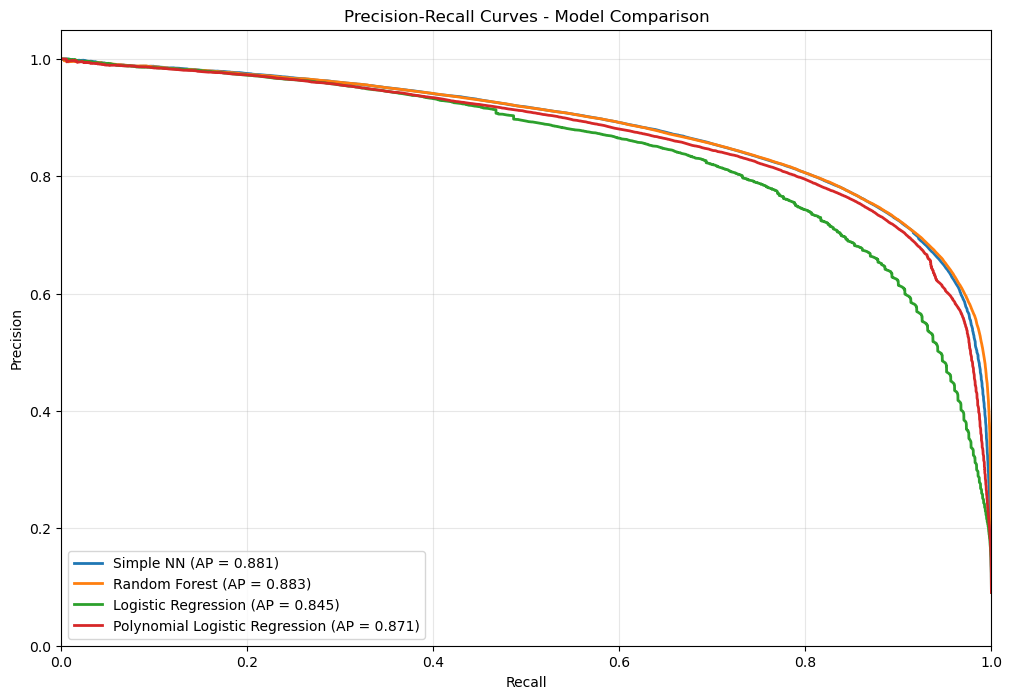

In [19]:
# Plot Precision-Recall curves
print("Creating Precision-Recall curves...")
visualizer.plot_precision_recall_curves(evaluation_results, save_path=results_dir / 'precision_recall_curves.png')

Creating performance comparison...


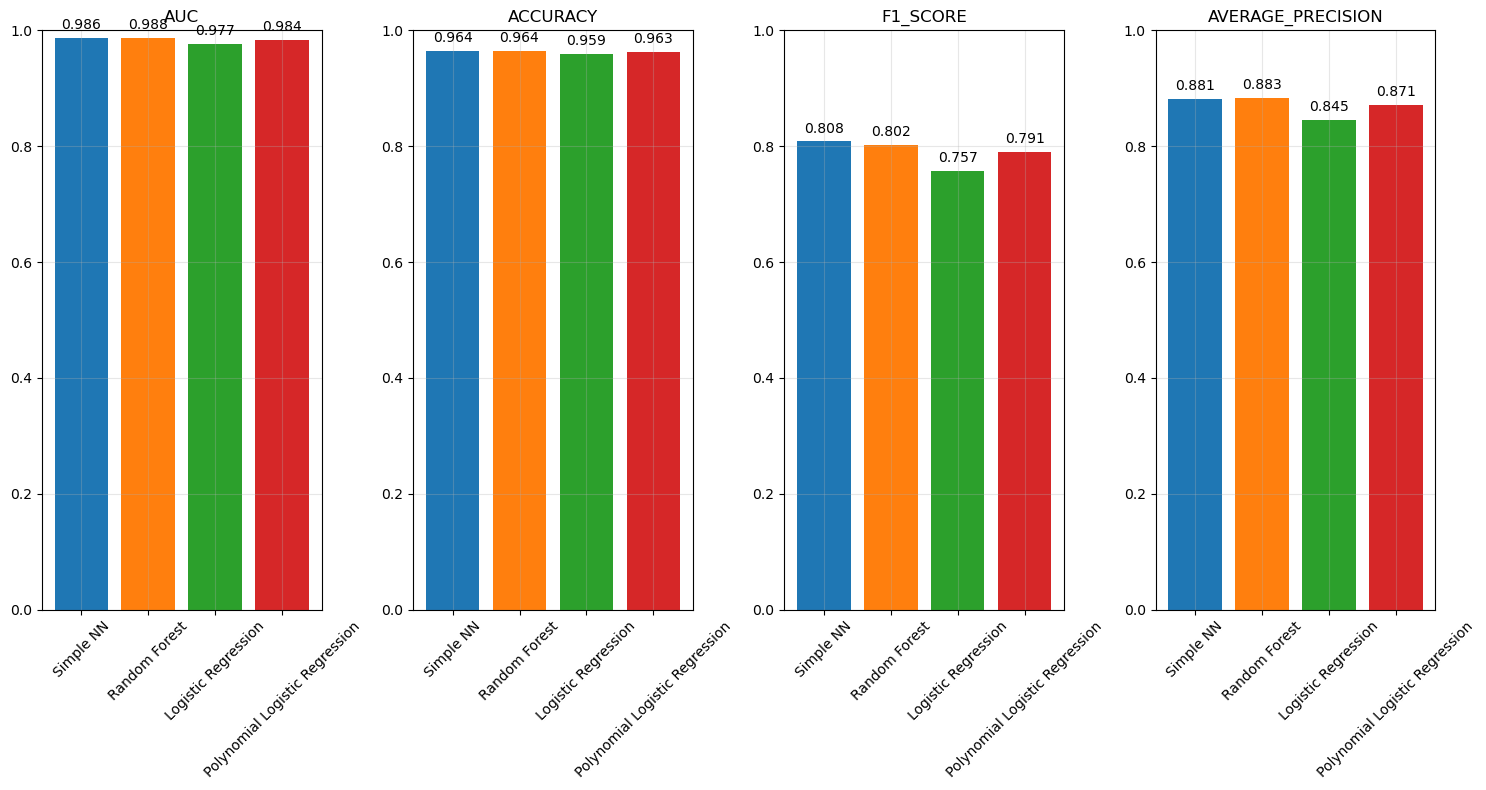

In [20]:
# Plot performance comparison
print("Creating performance comparison...")
visualizer.plot_performance_comparison(evaluation_results, save_path=results_dir / 'performance_comparison.png')

In [21]:
## 6. Edge Probability Heatmaps

## 6. Edge Probability Heatmaps

In [22]:
# Create degree grids for heatmap visualization
source_degrees = features[:, 0]
target_degrees = features[:, 1]

source_bins, target_bins, grid_features = create_degree_grid(
    source_degrees, target_degrees, n_bins=50
)

print(f"Created degree grid for visualization:")
print(f"  Source degree range: {source_bins.min():.0f} - {source_bins.max():.0f}")
print(f"  Target degree range: {target_bins.min():.0f} - {target_bins.max():.0f}")
print(f"  Grid size: {len(source_bins)} x {len(target_bins)} = {len(grid_features)} points")

Created degree grid for visualization:
  Source degree range: 0 - 15036
  Target degree range: 0 - 98
  Grid size: 50 x 50 = 2500 points


Creating individual prediction heatmaps...
Creating prediction heatmaps for all models...
Creating heatmap for Simple NN...


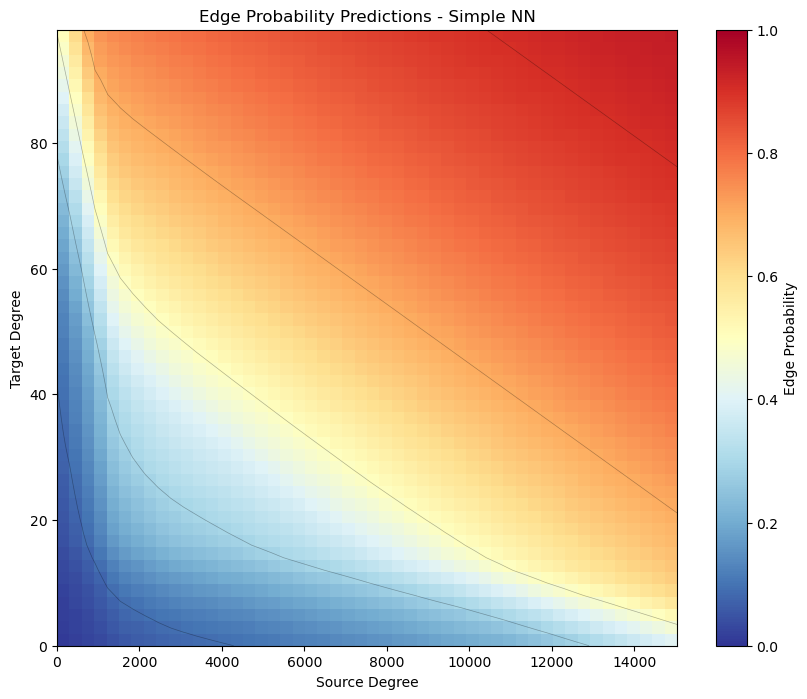

Creating heatmap for Random Forest...


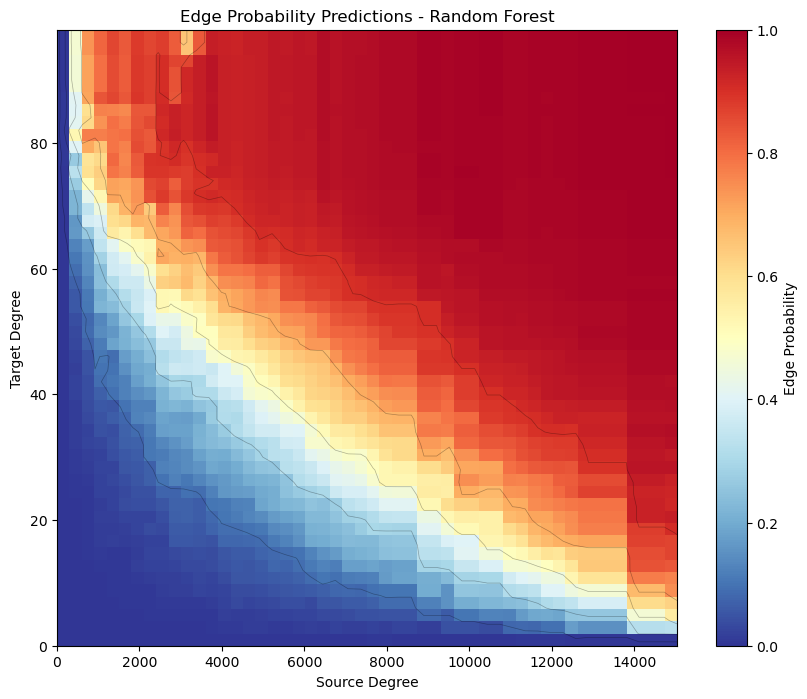

Creating heatmap for Logistic Regression...


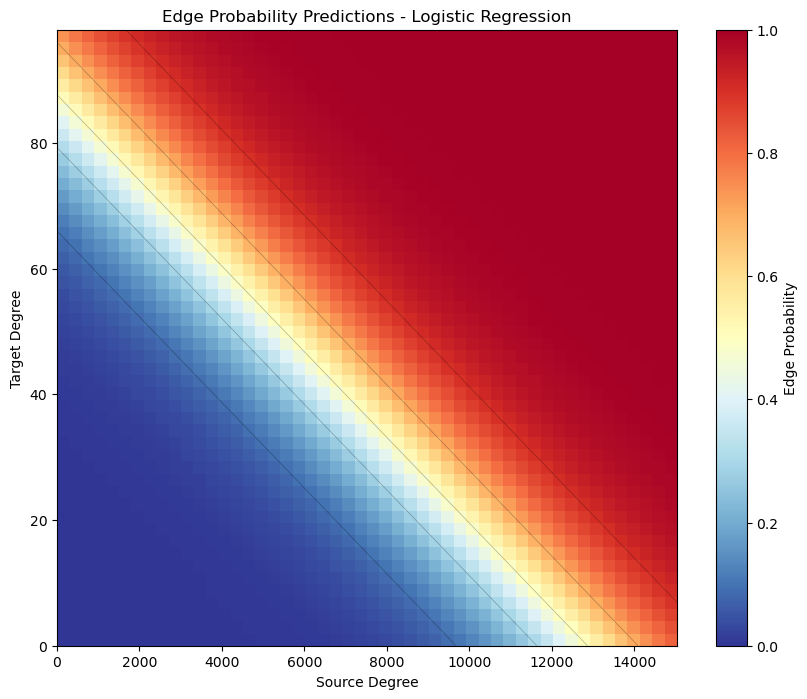

Creating heatmap for Polynomial Logistic Regression...


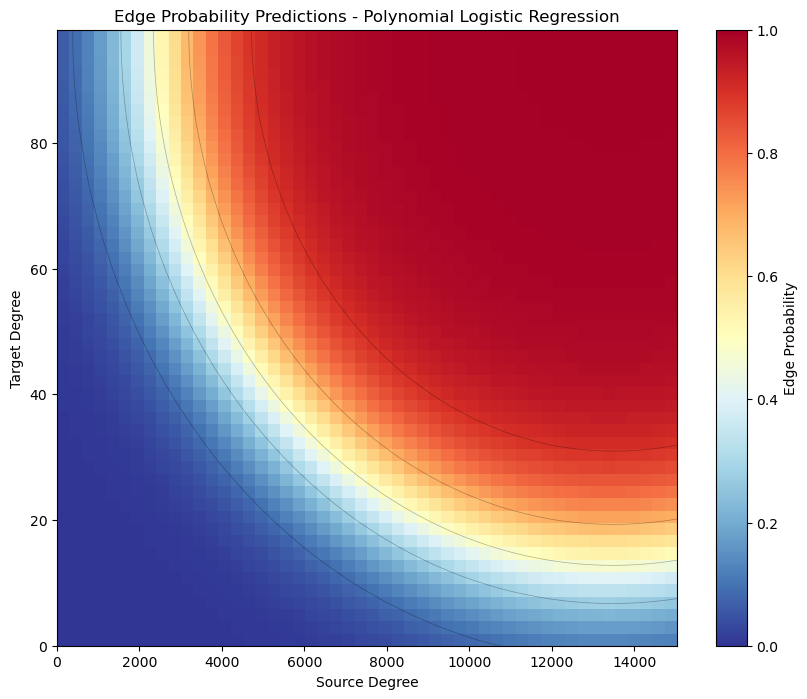

In [23]:
# Create individual heatmaps for each model
print("Creating individual prediction heatmaps...")
visualizer.create_all_prediction_heatmaps(
    training_results, source_bins, target_bins, 
    save_dir=str(results_dir)
)

In [24]:
## 7. Summary and Conclusions

## 7. Summary and Conclusions

In [25]:
# Summary analysis
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

print(f"\nDataset:")
print(f"  Edge file: {EDGE_FILE_PATH.name}")
print(f"  Total samples: {len(features):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Positive ratio: {np.mean(labels):.1%}")

print(f"\nBest Performing Models:")
best_auc_model = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['AUC']
print(f"  Overall Best (AUC): {best_auc_model} (AUC = {best_auc_score:.4f})")

for metric in ['Accuracy', 'F1 Score', 'RMSE', 'Correlation']:
    if metric in ['RMSE']:
        best_idx = comparison_df[metric].idxmin()
        best_value = comparison_df[metric].min()
        direction = "(lower is better)"
    else:
        best_idx = comparison_df[metric].idxmax()
        best_value = comparison_df[metric].max()
        direction = "(higher is better)"
    
    best_model = comparison_df.loc[best_idx, 'Model']
    print(f"  Best {metric}: {best_model} ({metric} = {best_value:.4f}) {direction}")

# Add test vs empirical comparison results if available
if 'test_empirical_comparison' in locals() and test_empirical_comparison is not None:
    print(f"\nTest Predictions vs Empirical Frequencies:")
    best_empirical_corr_model = test_empirical_df.iloc[0]['Model']
    best_empirical_corr = test_empirical_df.iloc[0]['Correlation vs Empirical']
    print(f"  Best Correlation with Empirical: {best_empirical_corr_model} (r = {best_empirical_corr:.6f})")
    
    best_empirical_mae_idx = test_empirical_df['MAE vs Empirical'].idxmin()
    best_empirical_mae_model = test_empirical_df.loc[best_empirical_mae_idx, 'Model']
    best_empirical_mae = test_empirical_df.loc[best_empirical_mae_idx, 'MAE vs Empirical']
    print(f"  Best MAE vs Empirical: {best_empirical_mae_model} (MAE = {best_empirical_mae:.6f})")
    
    # Report matching statistics
    avg_match_ratio = test_empirical_df['Match Ratio'].mean()
    print(f"  Average match ratio: {avg_match_ratio:.1%} of test samples matched with empirical data")

print(f"\nKey Insights:")

# Performance analysis
auc_scores = comparison_df['AUC'].values
if np.max(auc_scores) - np.min(auc_scores) < 0.05:
    print(f"  - All models show similar AUC performance (range: {np.min(auc_scores):.3f} - {np.max(auc_scores):.3f})")
else:
    print(f"  - Significant performance differences observed (AUC range: {np.min(auc_scores):.3f} - {np.max(auc_scores):.3f})")

# Model complexity vs performance
nn_auc = comparison_df[comparison_df['Model'] == 'Simple NN']['AUC'].values[0]
logistic_auc = comparison_df[comparison_df['Model'] == 'Logistic Regression']['AUC'].values[0]

if nn_auc - logistic_auc > 0.05:
    print(f"  - Neural Network shows substantial improvement over Logistic Regression")
elif abs(nn_auc - logistic_auc) < 0.02:
    print(f"  - Neural Network and Logistic Regression show similar performance")
else:
    print(f"  - Neural Network shows modest improvement over Logistic Regression")

# Correlation analysis
correlations = comparison_df['Correlation'].values
best_corr = np.max(correlations)
if best_corr > 0.8:
    print(f"  - Strong correlation between predictions and true probabilities (max: {best_corr:.3f})")
elif best_corr > 0.5:
    print(f"  - Moderate correlation between predictions and true probabilities (max: {best_corr:.3f})")
else:
    print(f"  - Weak correlation between predictions and true probabilities (max: {best_corr:.3f})")

# Test vs empirical comparison insights
if 'test_empirical_comparison' in locals() and test_empirical_comparison is not None:
    empirical_correlations = test_empirical_df['Correlation vs Empirical'].values
    best_empirical_corr_val = np.max(empirical_correlations)
    if best_empirical_corr_val > 0.8:
        print(f"  - Strong correlation between test predictions and empirical frequencies (max: {best_empirical_corr_val:.3f})")
    elif best_empirical_corr_val > 0.5:
        print(f"  - Moderate correlation between test predictions and empirical frequencies (max: {best_empirical_corr_val:.3f})")
    else:
        print(f"  - Weak correlation between test predictions and empirical frequencies (max: {best_empirical_corr_val:.3f})")
        
    print(f"  - Gap between test performance and empirical accuracy reveals generalization challenges")

print(f"\nFiles Generated:")
generated_files = list(results_dir.glob('*'))
for file_path in sorted(generated_files):
    print(f"  - {file_path.name}")

print(f"\nAll results saved to: {results_dir}")
print("=" * 80)

MODEL COMPARISON SUMMARY

Dataset:
  Edge file: AeG.sparse.npz
  Total samples: 5,790,477
  Test samples: 1,158,096
  Positive ratio: 9.1%

Best Performing Models:
  Overall Best (AUC): Random Forest (AUC = 0.9876)
  Best Accuracy: Random Forest (Accuracy = 0.9643) (higher is better)
  Best F1 Score: Simple NN (F1 Score = 0.8081) (higher is better)
  Best RMSE: Random Forest (RMSE = 0.1588) (lower is better)
  Best Correlation: Random Forest (Correlation = 0.8336) (higher is better)

Test Predictions vs Empirical Frequencies:
  Best Correlation with Empirical: Random Forest (r = 0.996119)
  Best MAE vs Empirical: Random Forest (MAE = 0.019008)
  Average match ratio: 51.6% of test samples matched with empirical data

Key Insights:
  - All models show similar AUC performance (range: 0.977 - 0.988)
  - Neural Network and Logistic Regression show similar performance
  - Strong correlation between predictions and true probabilities (max: 0.834)
  - Strong correlation between test prediction

In [26]:
# Final recommendation
print("\nRECOMMENDATION:")
print("-" * 20)

best_overall = comparison_df.iloc[0]
print(f"For edge probability prediction on this dataset, the {best_overall['Model']} "
      f"performs best overall with:")
print(f"  - AUC: {best_overall['AUC']:.4f}")
print(f"  - Accuracy: {best_overall['Accuracy']:.4f}")
print(f"  - F1 Score: {best_overall['F1 Score']:.4f}")
print(f"  - RMSE: {best_overall['RMSE']:.4f}")

# Training time consideration
print(f"\nTraining time considerations:")
for model_name, result in training_results.items():
    if model_name != 'data_splits':
        training_time = result['training_result']['training_time']
        print(f"  - {model_name}: {training_time:.2f} seconds")

print(f"\nFor production use, consider the trade-off between model performance and training time.")


RECOMMENDATION:
--------------------
For edge probability prediction on this dataset, the Random Forest performs best overall with:
  - AUC: 0.9876
  - Accuracy: 0.9643
  - F1 Score: 0.8025
  - RMSE: 0.1588

Training time considerations:
  - Simple NN: 178.14 seconds
  - Random Forest: 17.61 seconds
  - Logistic Regression: 0.83 seconds
  - Polynomial Logistic Regression: 1.33 seconds

For production use, consider the trade-off between model performance and training time.


In [27]:
# First, reload the evaluator with updated analytical approximation methods
import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import ModelEvaluator

# Create new evaluator instance
evaluator = ModelEvaluator()

# Check if empirical frequency file exists for validation
if EMPIRICAL_FREQ_FILE.exists():
    print(f"Loading empirical frequencies for analytical validation: {EMPIRICAL_FREQ_FILE}")
    
    # Load empirical frequency data
    empirical_df = evaluator.load_empirical_frequencies(str(EMPIRICAL_FREQ_FILE))
    
    # Extract degree combinations and frequencies
    source_degrees_empirical = empirical_df['source_degree'].values
    target_degrees_empirical = empirical_df['target_degree'].values
    empirical_frequencies = empirical_df['empirical_frequency'].values
    
    # Get total number of edges from the edge matrix
    total_edges_m = evaluator.get_total_edges_from_file(str(EDGE_FILE_PATH))
    
    # Validate analytical approximation against empirical frequencies
    validation_results = evaluator.validate_analytical_approximation_vs_empirical(
        source_degrees_empirical, target_degrees_empirical, empirical_frequencies, total_edges_m
    )
    
    print("\nAnalytical approximation validation completed!")
    
else:
    print("Empirical frequency file not found. Skipping analytical validation.")
    print("Run the edge frequency analysis first to generate empirical frequencies.")
    validation_results = None

Loading empirical frequencies for analytical validation: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
Loaded empirical frequencies from: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
  Records: 13167
  Source degree range: 1 - 15036
  Target degree range: 1 - 98
  Frequency range: 0.000001 - 1.004902
Loaded edge matrix from /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/AeG.sparse.npz
  Shape: (402, 20945)
  Total edges: 526407

Analytical Approximation Validation vs Empirical:
  Total edges (m): 526407
  MAE vs Empirical: 0.094323
  RMSE vs Empirical: 0.154343
  R² vs Empirical: 0.832818
  Correlation vs Empirical: 0.959711
  Mean Analytical: 0.222832
  Mean E

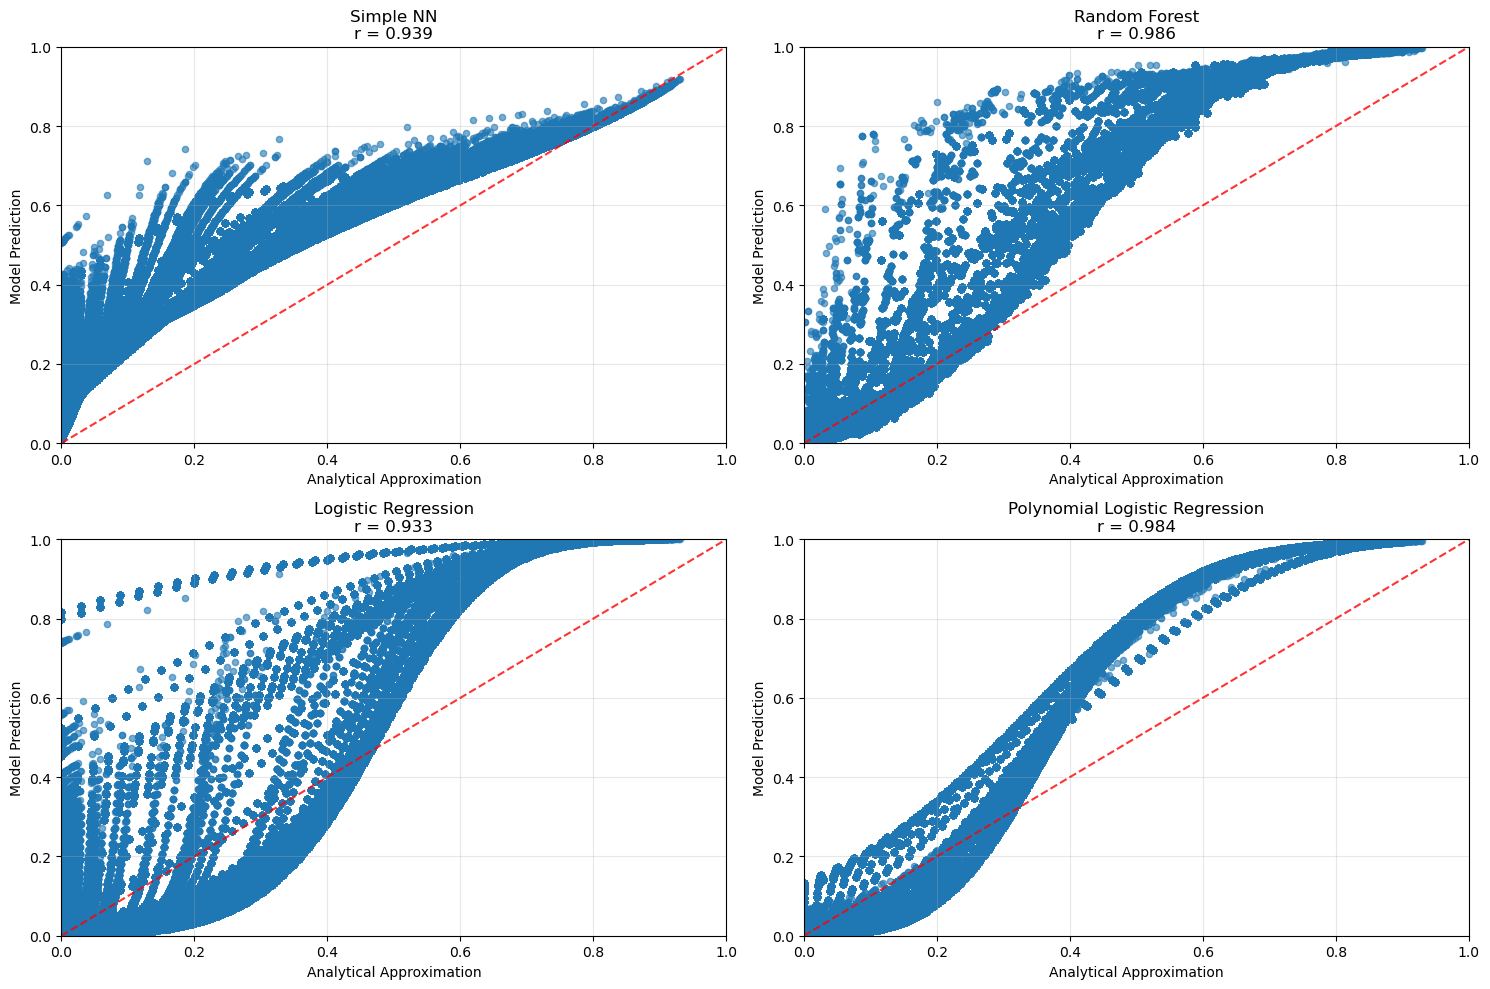

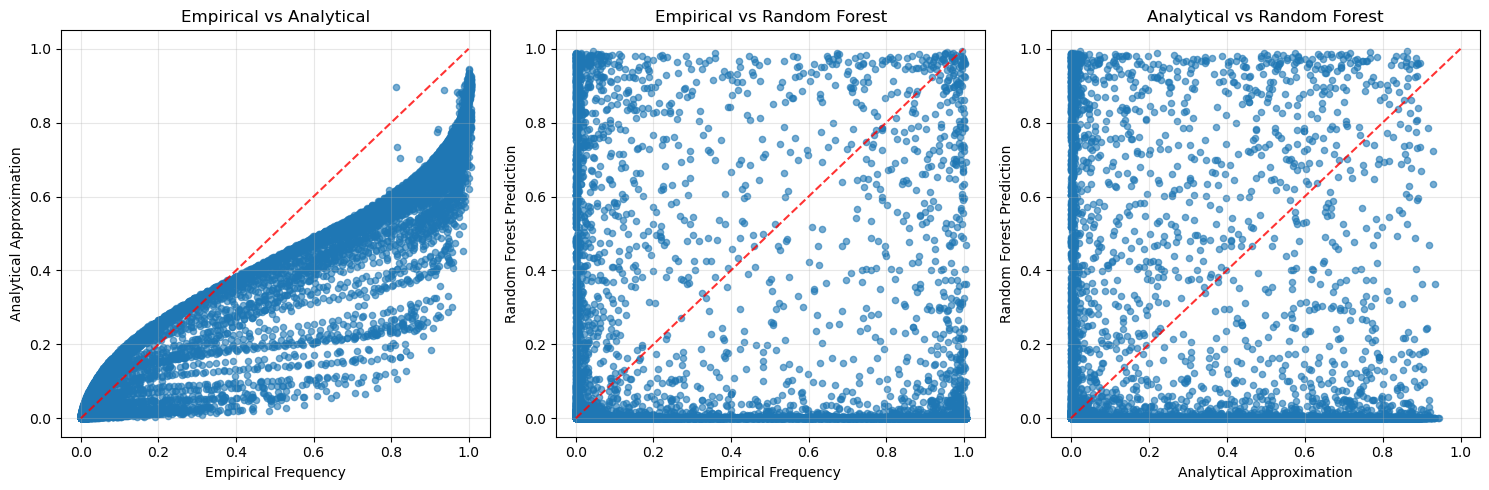

Three-way comparison plot created showing empirical frequencies, analytical approximation, and model predictions!


In [28]:
# Visualize model predictions vs analytical approximation
visualizer.plot_models_vs_analytical_comparison(
    analytical_comparison,
    save_path=results_dir / 'models_vs_analytical_scatter.png'
)

# If we have validation results, create a three-way comparison
if validation_results is not None:
    # Get best model name
    best_analytical_model = analytical_df.iloc[0]['Model']
    
    # Create three-way comparison plot
    visualizer.plot_three_way_comparison(
        str(EMPIRICAL_FREQ_FILE), analytical_comparison, validation_results, best_analytical_model,
        save_path=results_dir / 'three_way_comparison.png'
    )
    
    print("Three-way comparison plot created showing empirical frequencies, analytical approximation, and model predictions!")
else:
    print("Skipping three-way comparison - no empirical validation data available.")

In [29]:
# Updated comprehensive summary including analytical approximation results
print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON WITH ANALYTICAL APPROXIMATION")
print("=" * 80)

print(f"\nDataset:")
print(f"  Edge file: {EDGE_FILE_PATH.name}")
print(f"  Total samples: {len(features):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Positive ratio: {np.mean(labels):.1%}")

print(f"\nBest Performing Models:")
best_auc_model = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['AUC']
print(f"  Overall Best (AUC): {best_auc_model} (AUC = {best_auc_score:.4f})")

# Add analytical approximation results if available
if 'analytical_comparison' in locals() and analytical_comparison is not None:
    print(f"\nAnalytical Approximation Analysis:")
    best_analytical_corr_model = analytical_df.iloc[0]['Model']
    best_analytical_corr = analytical_df.iloc[0]['Correlation vs Analytical']
    print(f"  Best correlation with analytical: {best_analytical_corr_model} (r = {best_analytical_corr:.6f})")
    
    best_analytical_mae_idx = analytical_df['MAE vs Analytical'].idxmin()
    best_analytical_mae_model = analytical_df.loc[best_analytical_mae_idx, 'Model']
    best_analytical_mae = analytical_df.loc[best_analytical_mae_idx, 'MAE vs Analytical']
    print(f"  Best MAE vs analytical: {best_analytical_mae_model} (MAE = {best_analytical_mae:.6f})")

# Add empirical validation results if available
if validation_results is not None:
    print(f"\nAnalytical Approximation Validation vs Empirical:")
    analytical_emp_corr = validation_results['correlation_vs_empirical']
    analytical_emp_mae = validation_results['mae_vs_empirical']
    analytical_emp_r2 = validation_results['r2_vs_empirical']
    print(f"  Analytical vs Empirical correlation: {analytical_emp_corr:.6f}")
    print(f"  Analytical vs Empirical MAE: {analytical_emp_mae:.6f}")
    print(f"  Analytical vs Empirical R²: {analytical_emp_r2:.6f}")

if 'test_empirical_comparison' in locals() and test_empirical_comparison is not None:
    print(f"\nTest Predictions vs Empirical Frequencies:")
    best_empirical_corr_model = test_empirical_df.iloc[0]['Model']
    best_empirical_corr = test_empirical_df.iloc[0]['Correlation vs Empirical']
    print(f"  Best correlation with empirical: {best_empirical_corr_model} (r = {best_empirical_corr:.6f})")

print(f"\nKey Insights:")

# Performance analysis
auc_scores = comparison_df['AUC'].values
if np.max(auc_scores) - np.min(auc_scores) < 0.05:
    print(f"  - All models show similar AUC performance (range: {np.min(auc_scores):.3f} - {np.max(auc_scores):.3f})")
else:
    print(f"  - Significant performance differences observed (AUC range: {np.min(auc_scores):.3f} - {np.max(auc_scores):.3f})")

# Analytical approximation insights
if 'analytical_comparison' in locals() and analytical_comparison is not None:
    analytical_correlations = analytical_df['Correlation vs Analytical'].values
    best_analytical_corr_val = np.max(analytical_correlations)
    if best_analytical_corr_val > 0.8:
        print(f"  - Strong correlation between model predictions and analytical approximation (max: {best_analytical_corr_val:.3f})")
    elif best_analytical_corr_val > 0.5:
        print(f"  - Moderate correlation between model predictions and analytical approximation (max: {best_analytical_corr_val:.3f})")
    else:
        print(f"  - Weak correlation between model predictions and analytical approximation (max: {best_analytical_corr_val:.3f})")

if validation_results is not None:
    if analytical_emp_corr > 0.8:
        print(f"  - Analytical approximation shows strong correlation with empirical frequencies")
    elif analytical_emp_corr > 0.5:
        print(f"  - Analytical approximation shows moderate correlation with empirical frequencies")
    else:
        print(f"  - Analytical approximation shows weak correlation with empirical frequencies")
        
    print(f"  - Analytical approximation provides theoretical baseline for edge probability prediction")

print(f"\nGenerated Files (including analytical results):")
generated_files = list(results_dir.glob('*'))
for file_path in sorted(generated_files):
    print(f"  - {file_path.name}")

print(f"\nAll results saved to: {results_dir}")
print("=" * 80)

COMPREHENSIVE MODEL COMPARISON WITH ANALYTICAL APPROXIMATION

Dataset:
  Edge file: AeG.sparse.npz
  Total samples: 5,790,477
  Test samples: 1,158,096
  Positive ratio: 9.1%

Best Performing Models:
  Overall Best (AUC): Random Forest (AUC = 0.9876)

Analytical Approximation Analysis:
  Best correlation with analytical: Random Forest (r = 0.985650)
  Best MAE vs analytical: Random Forest (MAE = 0.028404)

Analytical Approximation Validation vs Empirical:
  Analytical vs Empirical correlation: 0.959711
  Analytical vs Empirical MAE: 0.094323
  Analytical vs Empirical R²: 0.832818

Test Predictions vs Empirical Frequencies:
  Best correlation with empirical: Random Forest (r = 0.996119)

Key Insights:
  - All models show similar AUC performance (range: 0.977 - 0.988)
  - Strong correlation between model predictions and analytical approximation (max: 0.986)
  - Analytical approximation shows strong correlation with empirical frequencies
  - Analytical approximation provides theoretical b